In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def compute_sift(img):
    sift = cv2.SIFT()
    kp, des = sift.detectAndCompute(img,None)
    return (kp, des)

def centroid_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    for (percent, color) in zip(hist, centroids):
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color, -1)
        startX = endX
    return bar

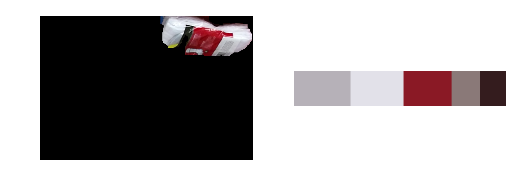

In [3]:
tote_stamp = '170331141533'
filename = 'tote/' + tote_stamp + '_obj.png'
image_BGR = cv2.imread(filename)
image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
mask = cv2.inRange(image_RGB, np.array((0,0,0)), np.array((0,0,0)))
image_RGBA = np.dstack((image_RGB, 255-mask))
pixels = image_RGBA.reshape((image_RGBA.shape[0] * image_RGBA.shape[1], 4))
filtered_pixels = np.array(filter(lambda x:x[3]==255,pixels))
clt = KMeans(n_clusters = 5)
clt.fit(filtered_pixels)
hist = centroid_histogram(clt)
h_obj, cc_obj = zip(*sorted(zip(hist, clt.cluster_centers_),reverse=True))
plt.subplot(121); plt.imshow(image_RGB); plt.axis('off');
bar = plot_colors(h_obj, cc_obj)
plt.subplot(122); plt.imshow(bar); plt.axis('off');

169 features detected


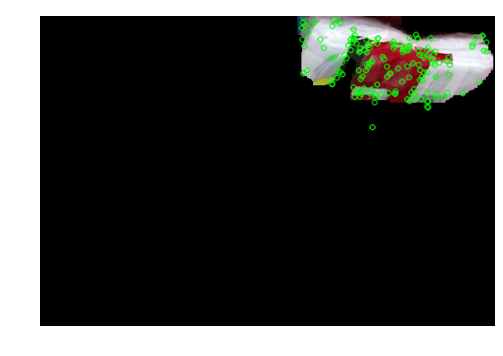

In [4]:
gray_image = cv2.cvtColor(image_RGB, cv2.COLOR_RGB2GRAY)
(kp_obj, des_obj) = compute_sift(gray_image)
kp_img = cv2.drawKeypoints(image_RGB,kp_obj,color=(0,255,0))
print('%d features detected' % len(kp_obj))
plt.imshow(kp_img); plt.axis('off');

## Load Item Descriptors

In [5]:
import os.path

def read_features_from_file(filename):
    """ Read feature properties and return in matrix form. """
    if os.path.getsize(filename) <= 0:
        return np.array([]), np.array([])
    f = np.load(filename)
    if f.size == 0:
        return np.array([]), np.array([])
    f = np.atleast_2d(f)
    return f[:,:7], f[:,7:] # feature locations, descriptors

def unpack_keypoint(kpts,desc):
    try:
        keypoints = [cv2.KeyPoint(x, y, _size, _angle, _response, int(_octave), int(_class_id))
                 for x, y, _size, _angle, _response, _octave, _class_id in list(kpts)]
        return keypoints, np.array(desc)
    except(IndexError):
        return np.array([]), np.array([])

### Load All Items

In [4]:
import glob
import os.path
item_folder = 'Training items/'
items = sorted(map(os.path.basename, glob.glob(item_folder + '*')))

In [ ]:
items

### Load Items in Location File

In [6]:
import json
with open('item_location_file.json') as data_file:
    ilf = json.load(data_file)
items = []
for item in ilf['tote']['contents']:
    items.append(item.title())

In [7]:
items

[u'Ice_Cube_Tray',
 u'Hanes_Socks',
 u'Reynolds_Wrap',
 u'Balloons',
 u'Ticonderoga_Pencils',
 u'Speed_Stick',
 u'Colgate_Toothbrush_4Pk',
 u'Mouse_Traps',
 u'Marbles',
 u'Black_Fashion_Gloves',
 u'Composition_Book',
 u'Tennis_Ball_Container',
 u'Irish_Spring_Soap',
 u'Plastic_Wine_Glass',
 u'Mesh_Cup',
 u'Flashlight',
 u'Hand_Weight',
 u'Band_Aid_Tape',
 u'Hinged_Ruled_Index_Cards',
 u'Measuring_Spoons']

In [8]:
import glob
import json
dc_list = []
for item in items:
    folder = 'Training items/' + item + '/'
    files = glob.glob(folder + '*_dc.json')
    for filename in files:
        with open(filename) as data_file:
            dominant_colors = json.load(data_file)
        dc_list.append((filename,dominant_colors))

In [9]:
kp_list = []
for item in items:
    folder = 'Training items/' + item + '/'
    files = glob.glob(folder + '*_sift.npy')
    for filename in files:
        kp, des = read_features_from_file(filename)
        kp, des = unpack_keypoint(kp, des)
        kp_list.append((filename,kp,des))

## Match Item Descriptors

In [10]:
def calc_EMD2(h_obj,cc_obj,h_ref,cc_ref):
    sig_obj = np.concatenate((np.reshape(np.array(h_obj),(len(h_obj),1)),
                              np.array(cc_obj)[:,0:3]),1)
    a64 = cv2.cv.fromarray(sig_obj)
    a32 = cv2.cv.CreateMat(a64.rows, a64.cols, cv2.cv.CV_32FC1)
    cv2.cv.Convert(a64, a32)
    sig_ref = np.concatenate((np.reshape(np.array(h_ref),(len(h_ref),1)),
                              np.array(cc_ref)[:,0:3]),1)
    b64 = cv2.cv.fromarray(sig_ref)
    b32 = cv2.cv.CreateMat(b64.rows, b64.cols, cv2.cv.CV_32FC1)
    cv2.cv.Convert(b64, b32)
    return cv2.cv.CalcEMD2(a32,b32,cv2.cv.CV_DIST_L2)

In [11]:
def calc_matches(des_obj,des_ref):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_obj,des_ref,k=2)
    good = 0
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good += 1
    return good

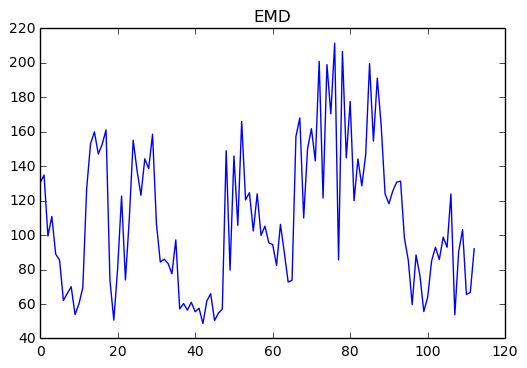

48.68 Marbles/Marbles_Top-Side_02
50.41 Marbles/Marbles_Top-Side_01
50.66 Balloons/Balloons_Top-Side_01
53.76 Measuring_Spoons/Measuring_Spoons_Bottom_01
53.87 Hanes_Socks/Hanes_Socks_Top-Side_02
54.71 Marbles/Marbles_Bottom_01
55.48 Mouse_Traps/Mouse_Traps_Top_01
55.62 Band_Aid_Tape/Band_Aid_Tape_Top-Side_01
56.41 Mouse_Traps/Mouse_Traps_Top-Side_01
56.98 Marbles/Marbles_Bottom-Side_01


In [12]:
ddc = []
refdc = []
for name, dc in dc_list:
    h_ref = dc['hist']
    cc_ref = dc['cluster_centers']
    emd = calc_EMD2(h_obj,cc_obj,h_ref,cc_ref)
    refdc.append(name)
    ddc.append(emd)
plt.plot(ddc), plt.title('EMD'), plt.show();
ddc, refdc = zip(*sorted(zip(ddc, refdc)))
for idx in range(10):
    print('%.2f %s' % (ddc[idx], refdc[idx][15:-8]))

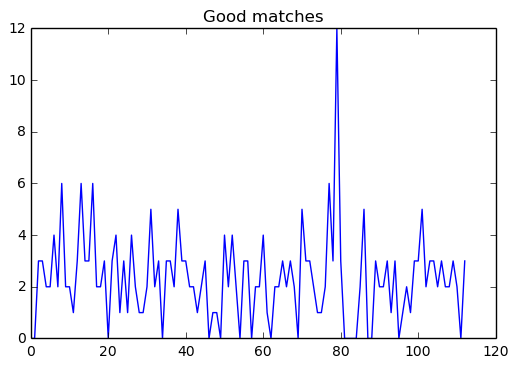

 12 Mesh_Cup/Mesh_Cup_Top-Side_01
  6 Reynolds_Wrap/Reynolds_Wrap_Top_01
  6 Reynolds_Wrap/Reynolds_Wrap_Top-Side_02
  6 Mesh_Cup/Mesh_Cup_Top_01
  6 Hanes_Socks/Hanes_Socks_Bottom_01
  5 Speed_Stick/Speed_Stick_Top-Side_02
  5 Mouse_Traps/Mouse_Traps_Top_01
  5 Irish_Spring_Soap/Irish_Spring_Soap_Bottom-Side_01
  5 Hinged_Ruled_Index_Cards/Hinged_Ruled_Index_Cards_Bottom_01
  5 Flashlight/Flashlight_Bottom-Side_02


In [13]:
dkp = []
refkp = []
for name, kp_ref, des_ref in kp_list:
    des_ref = des_ref.astype('float32')
    good = calc_matches(des_obj, des_ref)
    refkp.append(name)
    dkp.append(good)
plt.plot(dkp), plt.title('Good matches'), plt.show();
dkp, refkp = zip(*sorted(zip(dkp, refkp),reverse=True))
for idx in range(10):
    print('%3d %s' % (dkp[idx], refkp[idx][15:-9]))

In [14]:
def duplicates(l1,l2):
    l = l1 + l2
    return [i for i, x in enumerate(l) if l.count(x) > 1]

In [15]:
dc_items = []
kp_items = []
idx = 0
while len(duplicates(dc_items,kp_items)) == 0:
    next_item = refdc[idx].split('/')[1]
    if not next_item in dc_items:
        dc_items.append(next_item)
    next_item = refkp[idx].split('/')[1]
    if not next_item in kp_items:
        kp_items.append(next_item)
    idx += 1
print('Found a common item after %d images: %s' % (idx, dc_items[duplicates(dc_items,kp_items)[0]]))

Found a common item after 5 images: Hanes_Socks
